In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, get_system_from_template, get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA

import os

os.chdir('../../')

In [2]:
EPS = 1e-16

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
K = 1
nlayers = 10

dirstr = 'V1Circuit'

lr_order = -3

sysname = 'V1Circuit'
behavior_type = "ISN_coeff"


In [3]:
# multivariate normal initialization variance
c_init_ords = np.array([0, 2, 5])
sigma_inits = np.array([1.0, 3.0])
start_rs = 1
num_rs = 5
random_seeds = np.arange(start_rs, num_rs+start_rs)

In [4]:
best_models = []
ME_its = []

alpha=0.05
frac_samps=0.5
tol = 0.005*np.ones((1,))
tol_inds = [2]

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol':tol,
    'tol_inds':tol_inds
}


silenced_pops = ['V']
for silenced in silenced_pops:
    param_dict = {'behavior_type':behavior_type,
                  'silenced':silenced}
    
    system = get_system_from_template("V1Circuit", param_dict)

    arch_dict = {'D':system.D, \
                 'K':K, \
                 'flow_type':flow_type, \
                 'repeats':nlayers, \
                 'post_affine':True}

    best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                       sigma_inits, random_seeds, dirstr, 
                                                       conv_dict)
    best_models.append(best_model)
    ME_its.append(ME_it)

{'type': 'ISN_coeff', 'mean': 0.0, 'std': 0.25, 'c_vals': array([1.]), 's_vals': array([5]), 'r_vals': array([0.]), 'silenced': 'V'}
ISN_coeff
0 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=1/
1 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=2/
2 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=3/
3 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=4/
4 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=5/
5 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=3.00_c=0_rs=1/
6 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=3.00_c=0_rs=2/
7 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=3.00_c=0_rs=3/
8 models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=3.00_c=0_rs=4/
9 models/V1Circuit/V

In [5]:
print(best_models)
print(ME_its)

['models/V1Circuit/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=10P_M_A_sigma=1.00_c=0_rs=4/']
[array(344)]


0
dist (200, 8)
log_q_z


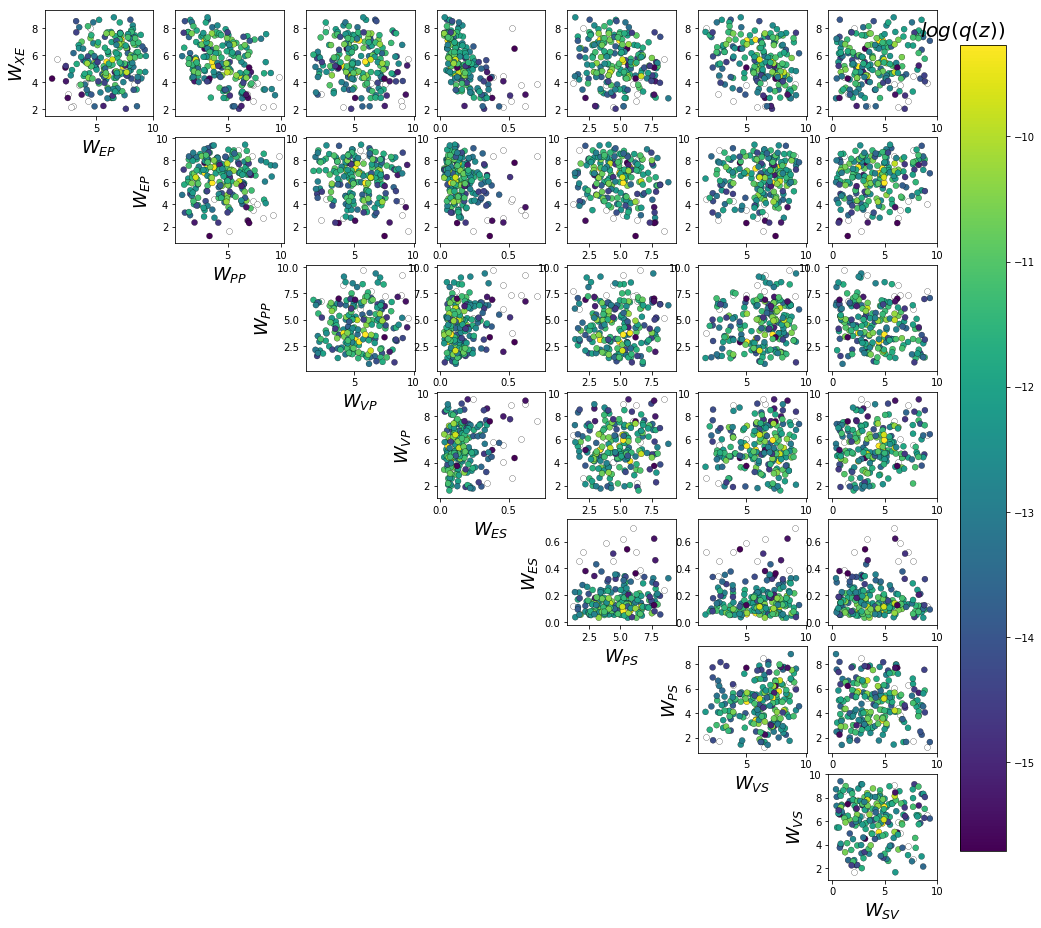

In [6]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
Zs, cs, axs = dsn_pairplots(best_models, 'Zs', system, system.D, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(16,16))


0
dist (200, 3)
log_q_z


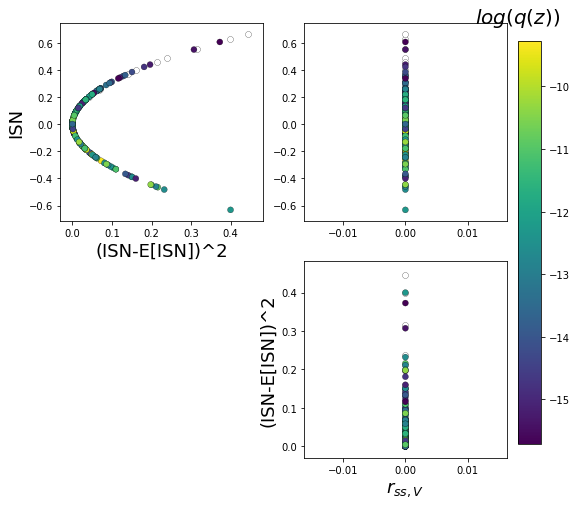

In [7]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
T_xs, cs, axs = dsn_pairplots(best_models, 'T_xs', system, system.num_suff_stats, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(8,8))


[6.73059794 5.01014299 3.98069949 3.45431301 2.73746466 2.35577007
 1.50098342 0.06781516]
[6.69694495 4.98509228]
Projection
beta [ 5.68375068e-02 -3.29131204e-03 -4.48509896e-03 -2.75065354e-04
  1.93280980e+00  4.01426864e-03 -8.12835517e-03 -1.71989280e-03]
v1 [-3.45213232e-01 -1.99919194e-01  5.45054072e-01  9.83227134e-03
 -5.19723376e-04  1.40797131e-01  2.34961262e-01 -6.84579161e-01]
v2 [-0.31162905  0.1049284   0.32099751  0.44629634  0.00628479  0.1892456
  0.45973103  0.58519358]
dot prods should be zero
beta * v1 -0.022582163684928182
beta * v2 -0.011456382420980134
v1 * v2 -4.718447854656915e-16


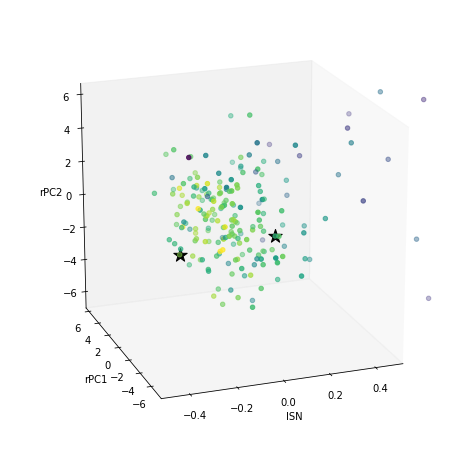

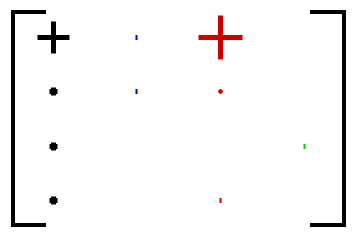

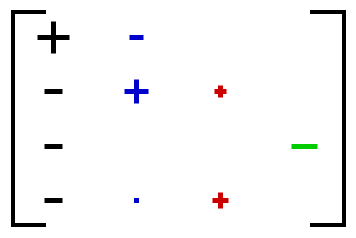

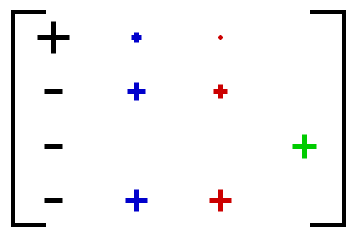

In [50]:
for i in range(len(silenced_pops)):
    silenced = silenced_pops[i]
    Z_mean = np.expand_dims(np.mean(Zs[i], 0), 0)
    Z_mc = Zs[i] - Z_mean

    reg = linear_model.LinearRegression()
    reg.fit(Z_mc, T_xs[i][:,0])
    beta = reg.coef_
    alpha = reg.intercept_

    # remove ISN regression dimension from the data
    Beta = np.expand_dims(beta, 1)

    Z_ISN = np.dot(Z_mc, Beta)
    Z_deISN = Z_mc - np.dot(Z_ISN, Beta.T)
    Z_PCA, evals, evecs = PCA(Z_deISN, 2)
    v1 = evecs[:,0]
    v2 = evecs[:,1]
    print(evals)
    print(np.var(Z_PCA, axis=0))

    print('Projection')
    print('beta', beta)
    print('v1', v1)
    print('v2', v2)

    print('dot prods should be zero')
    print('beta * v1', np.dot(beta, v1))
    print('beta * v2', np.dot(beta, v2))
    print('v1 * v2', np.dot(v1, v2))
    
    pos_ISN_targ = 0.25
    d = (T_xs[i][:,0] - pos_ISN_targ)**2
    pos_ISN = np.argmin(d)
    
    neg_ISN_targ = -0.25
    d = (T_xs[i][:,0] - neg_ISN_targ)**2
    neg_ISN = np.argmin(d)
    
    pos_ISN_Z = Zs[i][pos_ISN]
    neg_ISN_Z = Zs[i][neg_ISN]
    np.savez('data/V1/ISNs_%s=0.npz' % silenced, pos_ISN_Z=pos_ISN_Z, neg_ISN_Z=neg_ISN_Z)
    
    # plot the 3D visualization
    Z_vis = np.concatenate([Z_ISN, Z_PCA], axis=1)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Z_vis[:,0], Z_vis[:,1], Z_vis[:,2], c=cs[0])
    ax.view_init(elev=20, azim=-110)
    
    ax.scatter(Z_vis[pos_ISN,0], Z_vis[pos_ISN,1], Z_vis[pos_ISN,2], c='k', marker='*', s=200.0)
    ax.scatter(Z_vis[neg_ISN,0], Z_vis[neg_ISN,1], Z_vis[neg_ISN,2], c='k', marker='*', s=200.0)
    
    ax.set_xlabel('ISN')
    ax.set_ylabel('rPC1')
    ax.set_zlabel('rPC2')
    ax.set_xlim([-0.5, 0.5])
    ax.grid(False)
    plt.show()
    
    # plot the matrices for the axes
    vs = [beta, v1, v2]
    space = 0.01
    for i in range(len(vs)):
        v = vs[i]
        plt.figure()
        x = space*np.arange(0, 4)
        y = space*np.arange(3, -1, -1)
        X, Y = np.meshgrid(x, y)
        red = [0.8, 0, 0]
        blue = [0, 0, 0.8]
        green = [0.0, 0.8, 0.0]
        c = ['k', blue, red, green, \
             'k', blue, red, green, \
             'k', blue, red, green, \
             'k', blue, red, green]
        s = np.array([1.0,  v[1], v[4], 0.0, \
                      v[0], v[2], v[5], 0.0, \
                      v[0],  0.0,  0.0, v[7], \
                      v[0], v[3], v[6], 0.0])
        vinds = [None, 1, 4, None, \
                 0, 2, 5, None, \
                 0, None, None, 7, \
                 0, 3, 6, None]
        for ii in range(4):
            for jj in range(4):
                ind = 4*ii + jj
                if (vinds[ind] is not None and v[vinds[ind]] < 0.0):
                    marker = '_'
                else:
                    marker = '+'
                    
                
                plt.scatter(X[ii,jj], Y[ii,jj], marker=marker, 
                            c=c[ind], s=1000.0*abs(s[ind]), 
                            linewidth=5.0)
        lw = 8
        plt.plot([-space/2, -space/2], [-space/2, np.max(x)+space/2], 'k-', lw=lw)
        plt.plot([-space/2, -space/8], [-space/2, -space/2], 'k-', lw=lw)
        plt.plot([-space/2, -space/8], [np.max(x)+space/2, np.max(x)+space/2], 'k-', lw=lw)
        plt.plot([np.max(y) + space/2, np.max(y)+space/2], [-space/2, np.max(x)+space/2], 'k-', lw=lw)
        plt.plot([np.max(y) + space/2, np.max(y) + space/8], [-space/2, -space/2], 'k-', lw=lw)
        plt.plot([np.max(y) + space/2, np.max(y) + space/8], [np.max(x)+space/2, np.max(x)+space/2], 'k-', lw=lw)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-space/2, np.max(y) + space/2])
        ax.set_ylim([-space/2, np.max(y) + space/2])
        plt.savefig('notebooks/images/V1/DSN_V1_ISN_%s=0_ax%d.png' % (silenced, i+1), transparent=True)
        plt.show()